In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import sys
import numpy as np
import plotly
import pandas as pd
import math
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
plotly.offline.init_notebook_mode(connected=False)#オフラインでグラフを操作する設定
warnings.filterwarnings('ignore')#ワーニング表示の削除
sns.set_style("whitegrid", {'grid.linestyle': '--'}) #グラフスタイルの設定

In [0]:
#一般的な正弦波
#SIN(x/T*2*PI())
def sin(x, T=256):
    return np.sin(x / T *2.0*np.pi)

In [0]:
#角速度増加一定な正弦波
#SIN(x/256*(1+x/(256/T)/25600)*2*PI())
def sin_k1(x, T=256):
    return np.sin(x / T *(1+x/(256/T)/2560)*2.0*np.pi)

In [0]:
#角速度増加加速度的
#SIN(x/T*(1+(x/(256/T))^2/25600)*2*PI())
def sin_k2(x, T=256):
    return np.sin(x / T *(1+(x/(256/T))**1.1/25600)*2.0*np.pi)

In [0]:
#振幅増加一定
#(1+x/(256/T)/25600)*SIN(x/T*2*PI())
def sin_s1(x, T=256):
    return (1+x/(256/T)/2560)*np.sin(x / T *2.0*np.pi)

In [0]:
#振幅増加加速度的
#(1+(x/(256/T))^2/25600)*SIN(x/T*2*PI())
def sin_s2(x, T=256):
    return (1+(x/(256/T))**1.2/25600)*np.sin(x / T *2.0*np.pi)

In [0]:
#平均値増加一定
#x/(256/T)/25600 + SIN(x/T*2*PI())
def sin_h1(x, T=256):
    return x/(256/T)/25600 + np.sin(x / T *2.0*np.pi)

In [0]:
#平均値増加加速度的
#(x/(256/T))^2/25600+SIN(x/T*2*PI())
def sin_h2(x, T=256):
    return (x/(256/T))**2/25600 + np.sin(x / T *2.0*np.pi)

In [0]:
def toy_problem(T1=256, ampl=0.00):
    x = np.arange(0, 10 * T1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))# ±0.05の範囲でランダムにノイズを乗せる
    return sin_k1(x) + noise

In [0]:
def y_correct(T2=256, ampl=0.00):
    x = np.arange(10 * T2, 10 * T2*1.5)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))# ±0.05の範囲でランダムにノイズを乗せる
    return sin_k1(x) + noise

In [0]:
def make_dataset(raw_data, n_prev=512, maxlen=512):
    data, target = [], []
    
    for i in range(len(raw_data) - maxlen):
        data.append(raw_data[i : i + maxlen])
        target.append(raw_data[i + maxlen])
        
    reshaped_data = np.array(data).reshape(len(data), maxlen, 1)
    reshaped_target = np.array(target).reshape(len(target), 1)
    
    return reshaped_data, reshaped_target

In [0]:
# a = np.genfromtxt('/content/drive/My Drive/分解能256系（テスト）/sin_256.csv', delimiter=',')

In [153]:
# a[:2560, 2:3].shape

(2560, 2)

In [0]:
# function = a[:2560, 1:3]

In [0]:
function = toy_problem(T1=256, ampl=0.00)

In [90]:
function.shape

(2560,)

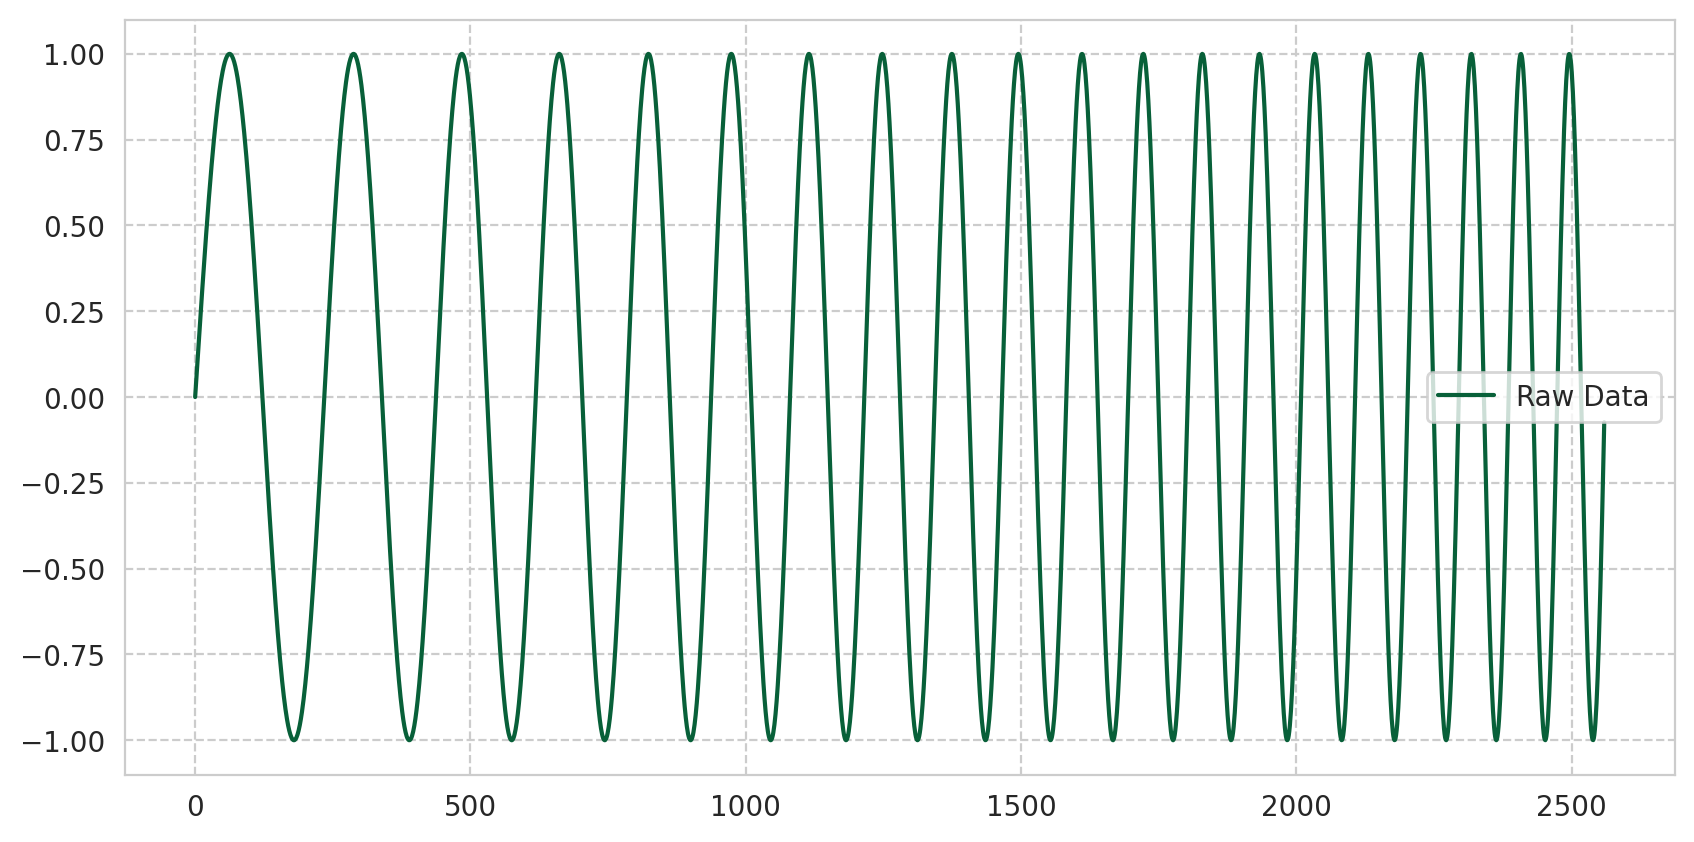

In [91]:
fig = plt.figure(figsize=(10,5),dpi=200)
sns.lineplot(
    color="#086039",
    data=function,
    label="Raw Data",
    # marker="o"
)

In [92]:
data, label = make_dataset(function, maxlen=512)
print(data.shape)
print(label.shape)

(2048, 512, 1)
(2048, 1)


In [93]:
future_test = data[2047].T
print(future_test)

[[ 0.63817275  0.58778525  0.53498952  0.47999848  0.42303433  0.36432765
   0.30411648  0.24264536  0.18016436  0.11692804  0.05319443 -0.01077601
  -0.07472144 -0.13837977 -0.20148967 -0.26379167 -0.32502924 -0.38494982
  -0.44330591 -0.49985608 -0.55436594 -0.60660918 -0.6563685  -0.7034365
  -0.74761658 -0.78872378 -0.82658555 -0.86104251 -0.8919491  -0.91917428
  -0.94260201 -0.96213186 -0.97767937 -0.98917651 -0.99657194 -0.99983129
  -0.99893732 -0.99389005 -0.98470677 -0.97142203 -0.95408749 -0.93277179
  -0.90756029 -0.8785547  -0.84587274 -0.80964768 -0.77002779 -0.72717575
  -0.68126802 -0.63249412 -0.58105587 -0.52716655 -0.47105003 -0.41293989
  -0.35307841 -0.29171558 -0.22910811 -0.16551828 -0.10121294 -0.03646231
   0.02846109  0.09328361  0.15773163  0.22153271  0.28441673  0.34611706
   0.40637167  0.46492429  0.52152545  0.5759336   0.62791613  0.67725039
   0.72372462  0.76713891  0.80730608  0.84405246  0.87721869  0.90666043
   0.93224897  0.95387186  0.9714334   

In [0]:
time_length = future_test.shape[1] #未来を予測するためのデータ長

In [0]:
future_result = np.empty((0)) #計算結果を格納するボックス

In [96]:
future_result

array([], dtype=float64)

In [0]:
length_of_sequence = data.shape[1]#入力データの長さ
in_out_neurons = 1# 出力のデータ数
n_hidden = 300# 隠れ層の数

In [0]:
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation('linear'))#リニアで良いのか？
optimizer = Adam(lr=1e-3)#最適化関数はアダムで良いのか？
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=2)

In [100]:
model.fit(data, label,
         batch_size=100, epochs=50,
         validation_split=0.1, callbacks=[early_stopping]
         )
# バリデーションってどうやって計算してるの？

Train on 1843 samples, validate on 205 samples
Epoch 1/50
1843/1843 [==============================] - 23s 12ms/step - loss: 0.0963 - val_loss: 0.0030
Epoch 2/50
1843/1843 [==============================] - 22s 12ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/50
1843/1843 [==============================] - 23s 12ms/step - loss: 4.9140e-04 - val_loss: 4.2247e-04
Epoch 4/50
1843/1843 [==============================] - 22s 12ms/step - loss: 1.6381e-04 - val_loss: 3.5125e-04
Epoch 5/50
1843/1843 [==============================] - 24s 13ms/step - loss: 1.0216e-04 - val_loss: 3.9124e-04
Epoch 6/50
1843/1843 [==============================] - 23s 12ms/step - loss: 8.6314e-05 - val_loss: 3.7500e-04


In [0]:
predicted = model.predict(data)

In [0]:
for step in range(1280):
    test_data= np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)
    
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    
    future_result = np.append(future_result, batch_predict)

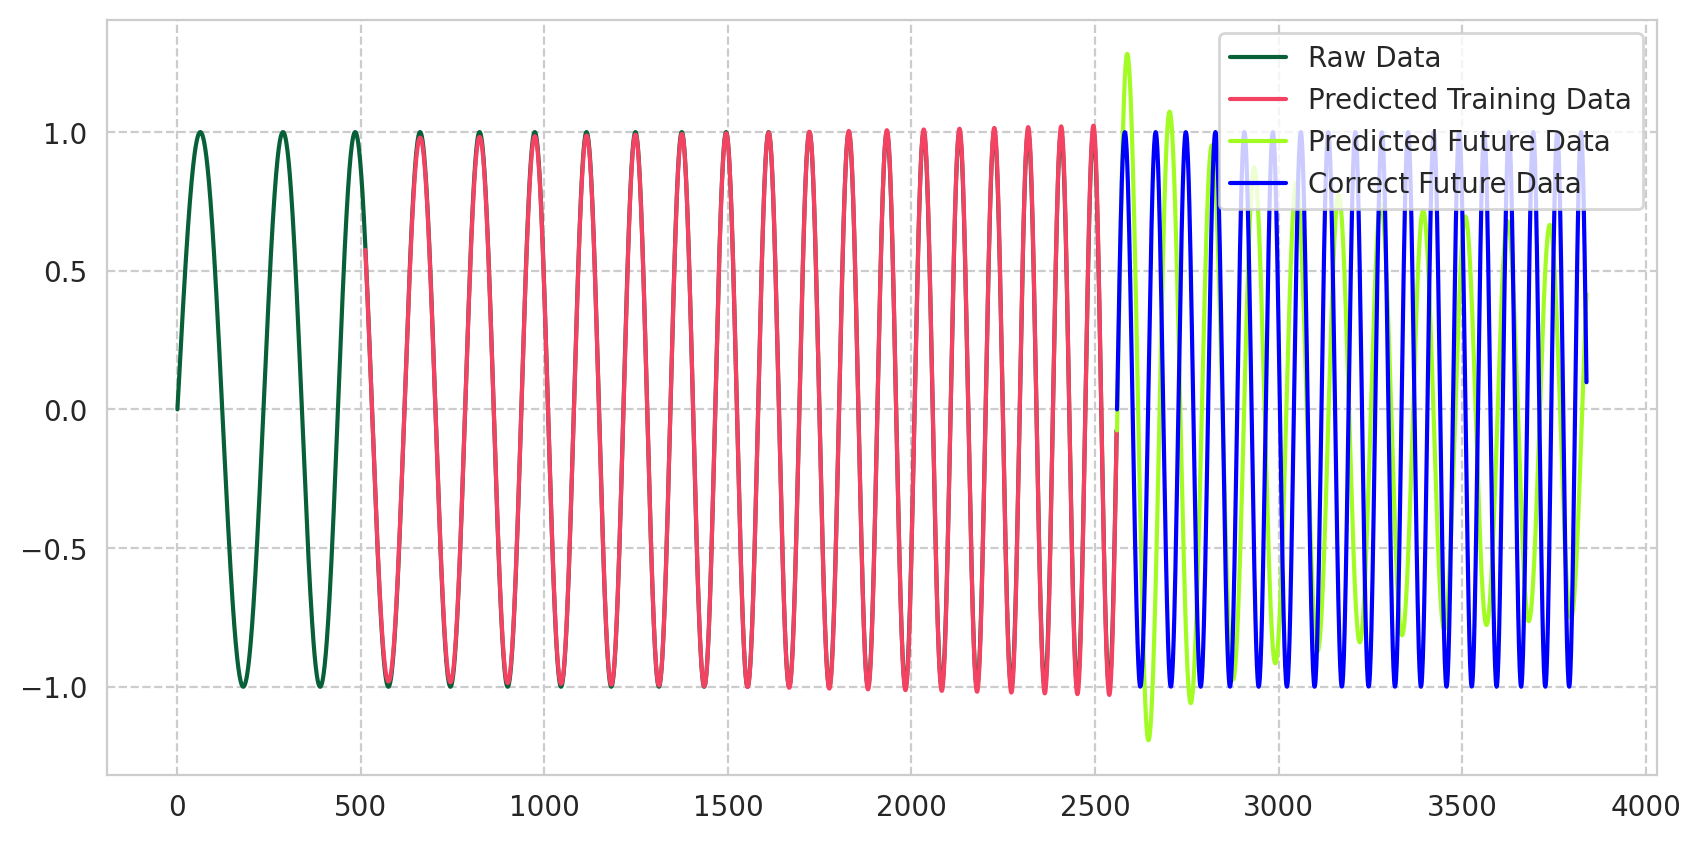

In [103]:
fig = plt.figure(figsize=(10,5),dpi=200)
sns.lineplot(
    color="#086039",
    data=function,
    label="Raw Data",
    # marker="o"
)

sns.lineplot(
    color="#f44262",
    x=np.arange(512, len(predicted)+512),
    y=predicted.reshape(-1),
    label="Predicted Training Data",
    # marker="o"
)

sns.lineplot(
    color="#a2fc23",
    y= future_result.reshape(-1),
    x = np.arange(0+len(function), len(future_result)+len(function)),
    label="Predicted Future Data",
    # marker="o"
)

sns.lineplot(
    color="B",
    y= y_correct(T2=256, ampl=0.00),
    x = np.arange(0+len(function), len(future_result)+len(function)),
    label="Correct Future Data",
    # marker="o"
)

In [0]:
fr = future_result.reshape(-1)

In [211]:
fr.shape

(1280,)

In [212]:
fr[1279]

-0.2051517814397812

In [151]:
for i in range(18):
  print(fr[[63+128*i,95+128*i]])



[-0.3019259  -1.31102264]
[-0.51813453 -1.06977534]
[-0.65074784 -0.88400972]
[-0.73857147 -0.72471964]
[-0.79630905 -0.58015722]
[-0.83088261 -0.44502118]
[-0.84612948 -0.31696507]
[-0.84450024 -0.19519068]
[-0.82778287 -0.07980401]
[-0.7974394   0.02853977]


IndexError: ignored

NameError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [26]:
import pandas as pd
# csvの読み取り
df= pd.read_csv('/content/drive/My Drive/分解能256系（テスト）/sin_256.csv')
print(df)

         1  0.024541229  0.0078125  0.0078125.1
0        2     0.049068   0.015625     0.015625
1        3     0.073565   0.023438     0.023438
2        4     0.098017   0.031250     0.031250
3        5     0.122411   0.039062     0.039062
4        6     0.146730   0.046875     0.046875
...    ...          ...        ...          ...
5114  5116    -0.098017  39.968750     0.968750
5115  5117    -0.073565  39.976562     0.976562
5116  5118    -0.049068  39.984375     0.984375
5117  5119    -0.024541  39.992188     0.992188
5118  5120     0.000000  40.000000     0.000000

[5119 rows x 4 columns]


In [29]:
a.shape

(5120, 4)

In [0]:
pwd

'/content'

In [0]:
import os

In [0]:
os.chdir('/content/drive/My Drive/正弦波テストデータ/標準系（平均値一定、振幅一定、角速度一定）/分解能256系/exl')

In [0]:
pwd

'/content/drive/My Drive/正弦波テストデータ/標準系（平均値一定、振幅一定、角速度一定）/分解能256系/exl'

In [0]:
np.savetxt('suzuki0.csv',a,delimiter=',')